# Predict Student Earnings -- Microsoft Data Science Capstone Challenge

## Information

- [Homepage of Competition](https://datasciencecapstone.org/competitions/2/student-earnings/page/5/)
- [Problem Description](https://datasciencecapstone.org/competitions/2/student-earnings/page/6/)
- [LeaderBoard of Public Score](https://datasciencecapstone.org/competitions/2/student-earnings/leaderboard/)

## General Idea of Solution

1. Minimum data wrangling
2. Single decision tree regressor as benchmark
3. Iteration for further data wrangling tactic, feature engineering
4. Train best single model
4. Stacking models

## Step 1: Minimum Data Wrangling

### 1.1 Gathering / Importing

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
##### Function 1: single model fitting and print out feature importance ######
def modelfit(model, X_train, y_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm on the data
    model.fit(X_train, y_train)
    
    #Predict training set:
    X_train_predictions = model.predict(X_train)
        
    if performCV:
        cv_score = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1)
        cv_score = np.sqrt(np.negative(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE Score (Train): %f" % np.sqrt(metrics.mean_squared_error(y_train, X_train_predictions)))
    
    if performCV:
        print ("CV Score : Mean  %.7g | Std  %.7g | Min  %.7g | Max  %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        )
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False).head(20)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [3]:
##### Function 2: random grid cv search for multiple models ######
### Reference: https://github.com/codiply/blog-ipython-notebooks/blob/master/scikit-learn-estimator-selection-helper.ipynb ###

"""
Modification:
1. RandomizedSearchCV instead of GridSearchCV
2. Add in scoring on test set with the best para with each
3. score_summary() re-write to compatible to Python 3.6 (Anaconda 5.1)
"""

class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.test_score = {}
    
    def fit(self, X, y, n_iter=10, cv=3, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error',
            refit=False, test_set=False):
        if test_set != False and refit == False:
            raise ValueError('Please set refit=Ture, if you are going to evaluate best model on test set')
        
        for key in self.keys:
            print("Running RandomizedSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = RandomizedSearchCV(model, params, n_iter=n_iter, cv=cv, n_jobs=n_jobs, 
                                    verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs
            
            # test_set = [test_predictor, test_label]
            if test_set:
                predictor, label = test_set
                score = np.negative(metrics.mean_squared_error(label, gs.predict(predictor)))
                self.test_score[key] = score
        
        if test_set:
            return (pd.DataFrame.from_dict(self.test_score, orient = 'index').
                    rename(columns={0:'test_set_score'}).sort_values('test_set_score', ascending=False))
                
    
    def score_summary(self, sort_by='mean_test'):
        def row(key, idx, scores, params):
            d = {
                 'estimator': key,
                 'mean_train':scores['mean_train_score'][idx],
                 'std_train': scores['std_train_score'][idx],
                 'mean_test': scores['mean_test_score'][idx],
                 'std_test': scores['std_test_score'][idx],
            }
            return pd.Series({**params[idx], **d})
        
        rows = [row(k, idx, self.grid_searches[k].cv_results_,
                    self.grid_searches[k].cv_results_['params']) 
                for k in self.keys
                for idx in range(len(self.grid_searches[k].cv_results_['params']))]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        return df

### 1.2 Assessing

In [4]:
X_train = pd.read_csv('train_values.csv', header = 0, index_col = 0)
y_train = pd.read_csv('train_labels.csv', header = 0, index_col = 0)
X_test = pd.read_csv('test_values.csv', header = 0, index_col = 0)

In [5]:
# Concatenate X_train and X_test
X_conc = pd.concat([X_train, X_test])
X_conc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26299 entries, 0 to 26298
Columns: 297 entries, academics__program_assoc_agriculture to student__size
dtypes: float64(287), int64(1), object(9)
memory usage: 59.8+ MB


In [6]:
# Check dtypes
X_conc.dtypes.value_counts()

float64    287
object       9
int64        1
dtype: int64

In [7]:
object_list = X_conc.columns[X_train.dtypes=='object'].tolist()
print (object_list)

['report_year', 'school__degrees_awarded_highest', 'school__degrees_awarded_predominant', 'school__institutional_characteristics_level', 'school__main_campus', 'school__online_only', 'school__ownership', 'school__region_id', 'school__state']


In [8]:
# Check duplicate
X_conc[X_conc.duplicated(keep=False)].isnull().sum(axis=1).sort_values().head(5)

# duplicated rows returned have extreme high portion of missing data
# so cannot judge whether it is real duplicated or not

row_id
19460    274
19919    274
3129     274
6157     274
3571     274
dtype: int64

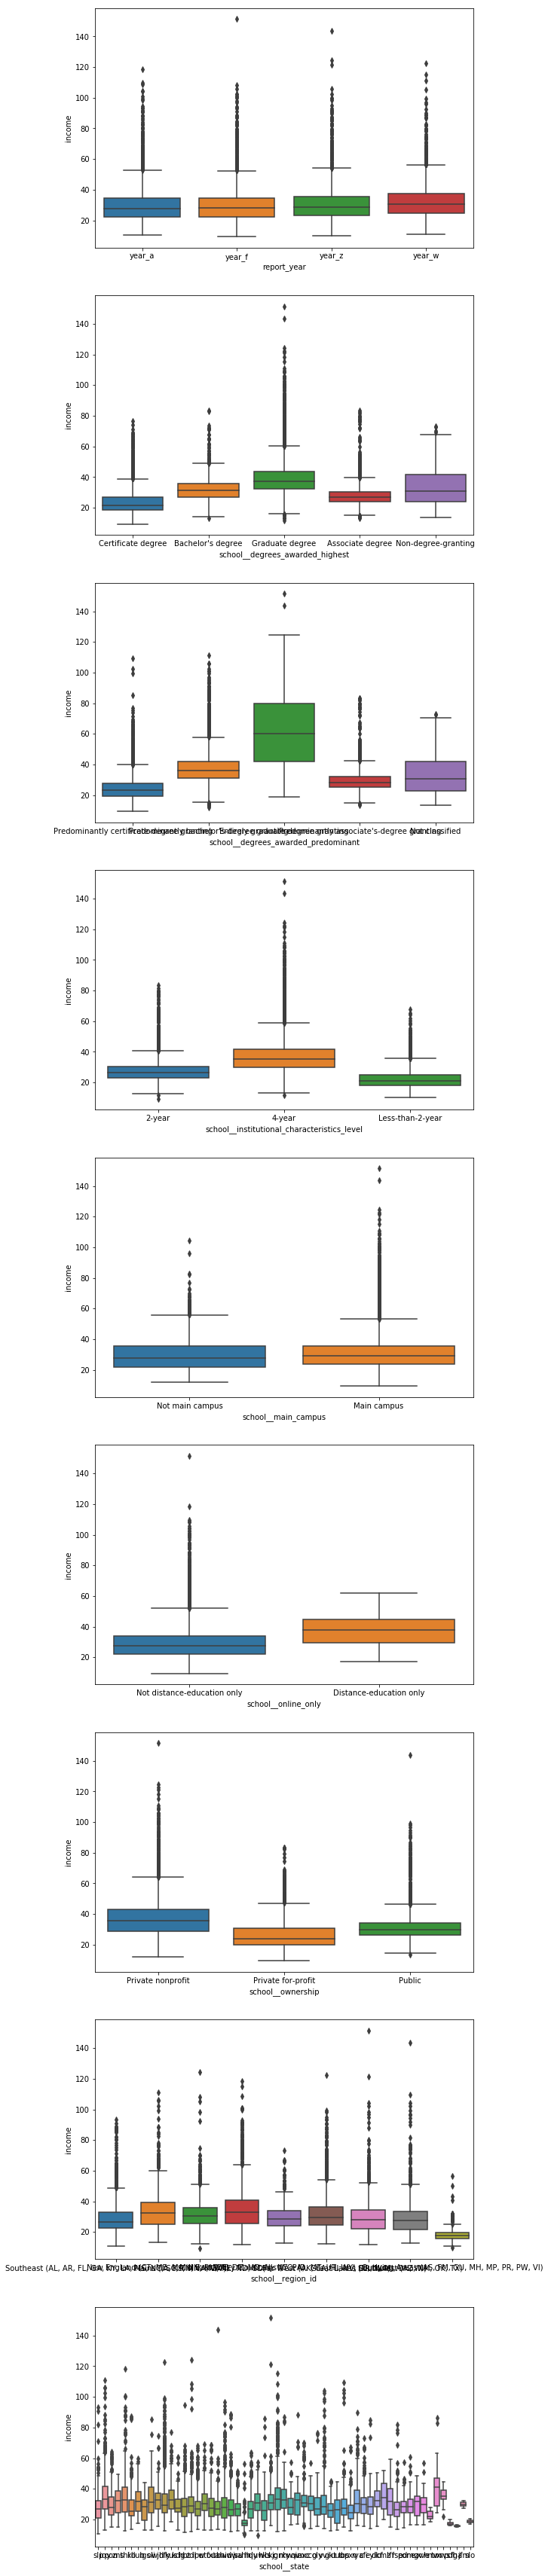

In [9]:
# Check dependency of categorical features and income
X_full = pd.concat([X_train[object_list], y_train], axis=1)

# Set up the matplotlib figure
f, axes = plt.subplots(9, 1, figsize=(9, 62))

for i in np.arange(0,9):
    sns.boxplot(x=X_full.columns.drop('income').tolist()[i], 
                   y='income', 
                   data=X_full, 
                   ax=axes[i])

In [10]:
# Find out features with missing values
X_conc.isnull().sum().sort_values(ascending=True).head(10) / len(X_train)

school__institutional_characteristics_level    0.000000
school__state                                  0.000000
school__main_campus                            0.000000
school__degrees_awarded_predominant_recoded    0.000000
school__degrees_awarded_predominant            0.000000
school__degrees_awarded_highest                0.000000
report_year                                    0.000000
school__region_id                              0.000000
school__ownership                              0.000000
student__demographics_age_entry                0.004384
dtype: float64

In [11]:
# Find out the high correlated features
# Iterative find out features with corr>0.9
X_corr = X_conc.corr()

high_corr = []
for i in range(X_corr.shape[0]):
    for j in range(i+1, X_corr.shape[0]):
        if X_corr.iloc[i,j]>0.9 or X_corr.iloc[i,j]<-0.9:
            high_corr.append(X_corr.iloc[[i],[j]].index[0])
            high_corr.append(X_corr.iloc[[i],[j]].columns[0])

High correlated features: 25


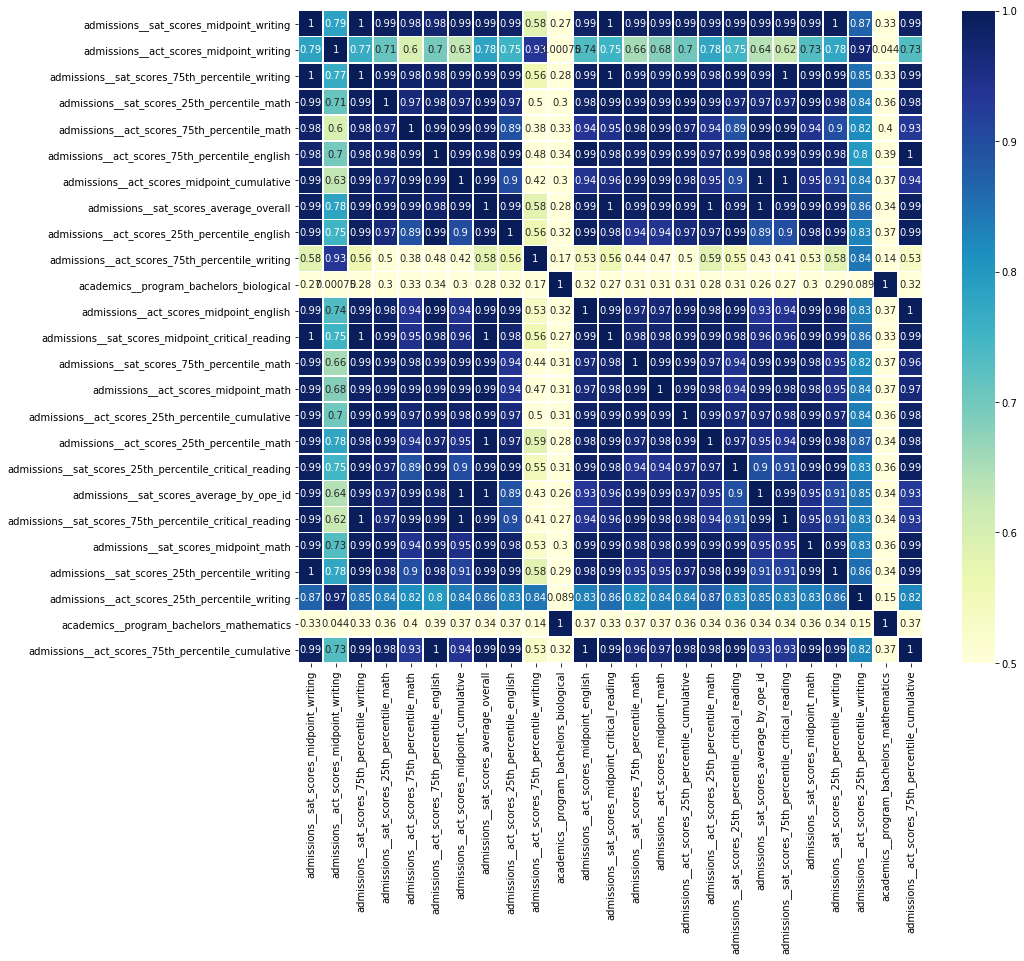

In [12]:
# Sliding out the high correlated features
high_corr = list(set(high_corr))
high_corr.remove('student__share_firstgeneration_parents_middleschool')  # due to 99.51% missing values
print ('High correlated features: ' + str(len(high_corr)))
X_high_corr = X_corr[high_corr].corr().abs()

# Plot heatmap
f, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(X_high_corr, cmap='YlGnBu', vmax=1, vmin=0.5, annot=True,
            linewidths=.5)

#### Identified Quality and Tidiness Issues

##### Quality (Dirty)

- Completeness
    - only 9 of 297 features has no missing value, and 8 of them are categorical features
    - 25 features have high correlation with others
- Validity: none
- Accuracy: none
- Consistency: none

##### Tidiness (Messy): None

##### Learning Algorithm Purpose

- 9 categorical features, and 7 of them has ordinal characteristic

### 1.3 Cleaning

Here only handling missing value and categorical features.

#### Define 1: transform categorical feature to ordinal, including `school__online_only` which is the only categorical feature has missing value

In [13]:
##### Code 1 for ordinal transformation #####
def trans_ord(df, col, vmap):
    df[col] = df[col].map(vmap)
    df[col] = pd.to_numeric(df[col], errors='coerce')

X_clean = X_conc.copy()

year_map = {'year_a':1,'year_f':2, 'year_w':3, 'year_z':4}
deg_map = {'Non-degree-granting':0,'Certificate degree':1, 'Associate degree':2, "Bachelor's degree":3, 'Graduate degree':4}
deg_pre_map = {'Not classified':0,'Predominantly certificate-degree granting':1, "Predominantly associate's-degree granting":2,
               "Predominantly bachelor's-degree granting":3, 'Entirely graduate-degree granting':4}
level_map = {'2-year':2,'4-year':4,'Less-than-2-year':0.5}
campus_map = {'Main campus':1,'Not main campus':0}
online_map = {'Not distance-education only':2, 'Distance-education only':1, np.NaN:0}

### Generate dict for State sorted by income median low to high ###
state_income = X_full[['school__state', 'income']].groupby(['school__state']).mean()

# 'nhl' is in test set without income, so estimated by region_id
nhl = X_full[['school__region_id', 'income']].groupby(['school__region_id']).mean().loc['Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)',:][0]
state_income.loc['nhl'] = nhl

# Sort and give rank
state_income = state_income.sort_values(by='income')
state_income['rank'] = range(1,59)

# Generate dict for state and rank
state_map = dict(zip(state_income.index.tolist(), state_income['rank'].tolist()))

### Update 7 categorical features to ordinal encoding
trans_ord(X_clean, 'report_year', year_map)
trans_ord(X_clean, 'school__degrees_awarded_highest', deg_map)
trans_ord(X_clean, 'school__degrees_awarded_predominant', deg_pre_map)
trans_ord(X_clean, 'school__institutional_characteristics_level', level_map)
trans_ord(X_clean, 'school__main_campus', campus_map)
trans_ord(X_clean, 'school__online_only', online_map)
trans_ord(X_clean, 'school__state', state_map)

In [14]:
##### Test 1 #####
ord_list = ['report_year','school__degrees_awarded_highest','school__degrees_awarded_predominant','school__institutional_characteristics_level','school__main_campus','school__online_only','school__state']
for i in ord_list:
    print ('Column "' + i + '" consists values: ' + str(X_clean[i].value_counts().index.tolist()))

Column "report_year" consists values: [2, 1, 4, 3]
Column "school__degrees_awarded_highest" consists values: [2, 4, 1, 3, 0]
Column "school__degrees_awarded_predominant" consists values: [1, 3, 2, 0, 4]
Column "school__institutional_characteristics_level" consists values: [4.0, 2.0, 0.5]
Column "school__main_campus" consists values: [1, 0]
Column "school__online_only" consists values: [0, 2, 1]
Column "school__state" consists values: [43, 23, 18, 55, 52, 24, 37, 19, 33, 57, 12, 20, 38, 49, 21, 46, 8, 47, 3, 31, 15, 16, 22, 35, 41, 40, 10, 54, 34, 14, 53, 36, 45, 26, 11, 9, 32, 48, 25, 17, 44, 29, 30, 50, 13, 39, 7, 28, 58, 51, 42, 56, 1, 6, 27, 2, 5, 4]


#### Define 2: fill missing values with 0, considering most of the features are sparse.

In [15]:
##### Code 2 #####
X_clean.fillna(value=0, inplace=True)

In [16]:
##### Test 2 #####
X_clean.isnull().sum().sort_values(ascending=False).head(3) / len(X_train)

student__size                                        0.0
academics__program_certificate_lt_1_yr_humanities    0.0
academics__program_certificate_lt_1_yr_legal         0.0
dtype: float64

#### Define 3: One-hot encodes the rest 2 categorical data without ordinal encoding

In [17]:
##### Code 3 #####
X_clean = pd.get_dummies(X_clean,columns=['school__ownership','school__region_id'])

In [18]:
##### Test 3 #####
X_clean.dtypes.value_counts()

float64    288
uint8       12
int64        7
dtype: int64

## Step 2: Benchmark Buildup

Considering the sparse and categorical features in this dataset, tree based models are used in this project.

The benchmark model needs to be easier to be interpreted, so single decision tree regressor is chosen here.

In [19]:
# Split out X_train, X_test
X_train_c = X_clean.iloc[:(-X_test.shape[0]), :].copy()
X_test_c = X_clean.iloc[(-X_test.shape[0]):, :].copy()

print (X_train_c.shape)
print (X_test_c.shape)

(17107, 307)
(9192, 307)


In [22]:
# RandomSearchCV for hyper-parameters
clf = DecisionTreeRegressor()
para_dict = {'max_depth':range(5,10),
             'min_samples_split':range(10,251,20),
             'min_samples_leaf':range(10,151,10)}

DT = RandomizedSearchCV(estimator = clf,
                        param_distributions = para_dict, 
                        scoring = 'neg_mean_squared_error', 
                        random_state = 8828,
                        verbose = 2,
                        n_jobs = -1, 
                        cv = 5,
                        n_iter=200)
DT.fit(X_train_c, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
          fit_params=None, iid=True, n_iter=200, n_jobs=-1,
          param_distributions={'max_depth': range(5, 10), 'min_samples_split': range(10, 251, 20), 'min_samples_leaf': range(10, 151, 10)},
          pre_dispatch='2*n_jobs', random_state=8828, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [23]:
print ('RMSE: ' + str(np.sqrt(-DT.best_score_)))
print (DT.best_params_)

RMSE: 6.0506488833665735
{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 9}


In [31]:
# Update benchmark model, and check feature importance
clf_benchmark = DecisionTreeRegressor(min_samples_split = 10,
                                      min_samples_leaf = 20,
                                      max_depth = 9)


Model Report
RMSE Score (Train): 5.333724
CV Score : Mean  6.048898 | Std  0.1340354 | Min  5.880829 | Max  6.269758


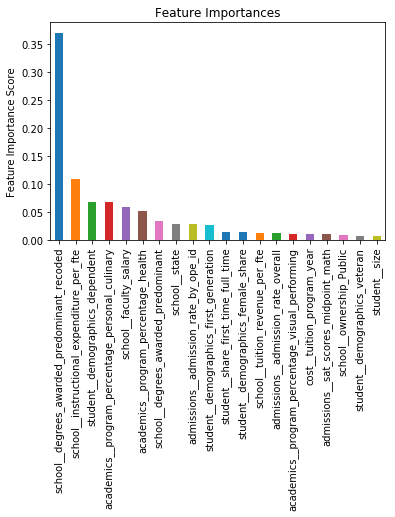

In [32]:
modelfit(clf_benchmark, X_train_c, y_train)

## Step 3: Interation of Further Data Wrangling

### 1. Remove high correlated features

To be clear, only the result of exploration is shown here.

In [20]:
corr_feature = ['admissions__act_scores_midpoint_cumulative',
                'admissions__sat_scores_25th_percentile_critical_reading',
                'admissions__act_scores_25th_percentile_english',
                'admissions__act_scores_25th_percentile_math',
                'admissions__act_scores_25th_percentile_writing', 
                'admissions__sat_scores_75th_percentile_critical_reading',
                'admissions__act_scores_75th_percentile_cumulative',
                'admissions__act_scores_75th_percentile_english',
                'admissions__sat_scores_75th_percentile_math',
                'admissions__act_scores_75th_percentile_writing',
                'student__demographics_first_generation']

X_train_EDA = X_train_c.copy()
X_test_EDA = X_test_c.copy()

X_train_EDA.drop(corr_feature, axis=1, inplace=True)
X_test_EDA.drop(corr_feature, axis=1, inplace=True)


Model Report
RMSE Score (Train): 5.331973
CV Score : Mean  6.049863 | Std  0.1349426 | Min  5.880425 | Max  6.272654


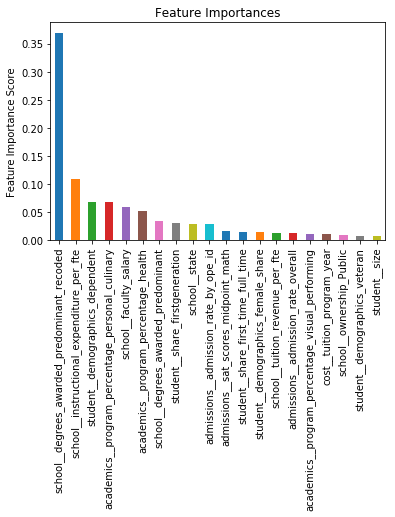

In [27]:
##### Check whether CV score increase ######
modelfit(clf_benchmark, X_train_EDA, y_train)

# CV has no significant increase so accept this wrangling approach

### 2. Fillna with mean / median / mode

After test by changing code in 1st part, the best imputing approach is fill 0.

## Step 4: Interation of Feature Engineering

### Interpolation of Important Features

Currently `fillna(value=0)` is used to impute all missing values.

However, based on the ranking of features importance from benchmark model, top features have over 25% missing values in original dataset.

To further improve RMSE, additional models are used to predict these missing values in high rank features, trained by other features.

In [28]:
##### Check Missing Percentage of Top 10 Important Features #####
top_imp = pd.Series(clf_benchmark.feature_importances_, X_train_EDA.columns).sort_values(ascending=False).head(10).index.tolist()
X_conc.isnull().sum()[top_imp] / len(X_conc)

school__degrees_awarded_predominant_recoded        0.000000
school__instructional_expenditure_per_fte          0.052131
student__demographics_dependent                    0.018480
academics__program_percentage_personal_culinary    0.047568
school__faculty_salary                             0.334690
academics__program_percentage_health               0.047568
school__degrees_awarded_predominant                0.000000
student__share_firstgeneration                     0.033689
school__state                                      0.000000
admissions__admission_rate_by_ope_id               0.489943
dtype: float64

It shows that `school__faculty_salary` is the most potential features to imporve model after interpolation.

### Interpolation on school__faculty_salary

In [21]:
##### Split out training features and labels from original dataset #####
X_conc_EDA = pd.concat([X_train_EDA, X_test_EDA]).drop('school__faculty_salary', axis=1)
X_conc_EDA = X_conc_EDA.join(X_conc[['school__faculty_salary']])

predictor = X_conc_EDA.columns[X_conc_EDA.columns != 'school__faculty_salary'].tolist()

train_rows = X_conc_EDA.index[X_conc_EDA.school__faculty_salary.notnull()]
pred_rows = X_conc_EDA.index[X_conc_EDA.school__faculty_salary.isnull()]

salary_train = X_conc_EDA.loc[train_rows].copy()
salary_unknown = X_conc_EDA.loc[pred_rows].copy()

In [41]:
##### Define search space for coarse search #####
models1 = { 
    'GRB': GradientBoostingRegressor(),
    'ETR': ExtraTreesRegressor(),
}

params1 = { 
    'GRB': {'learning_rate':[0.03, 0.1, 0.3, 1],
            'n_estimators':[200, 400, 600],
            'min_samples_split':[2, 6, 10],
            'random_state':[8828]},
    'ETR': {'n_estimators':[400, 600],
            'max_features':['sqrt', 'auto'],
            'min_samples_split':[2, 6, 10],
            'random_state':[8828]},
}

In [42]:
estm1 = EstimatorSelectionHelper(models1,params1)
estm1.fit(salary_train[predictor], salary_train.school__faculty_salary, n_iter=5, cv=3, n_jobs=-1, verbose=2)

Running RandomizedSearchCV for GRB.
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.5min finished


Running RandomizedSearchCV for ETR.
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.0min finished


In [43]:
estm1.score_summary()

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,estimator,learning_rate,max_features,mean_test,mean_train,min_samples_split,n_estimators,random_state,std_test,std_train
6,ETR,NaN,auto,-1.21262e+06,-30071.7,6,600,8828,939066,7507.13
7,ETR,NaN,sqrt,-1.24114e+06,-0.00757137,2,400,8828,888672,0.00206081
8,ETR,NaN,sqrt,-1.29066e+06,-128892,6,600,8828,869458,20133
9,ETR,NaN,sqrt,-1.29411e+06,-128995,6,400,8828,871184,20635.8
5,ETR,NaN,sqrt,-1.33703e+06,-280593,10,600,8828,857541,51260.2
1,GRB,0.1,NaN,-1.67213e+06,-792204,6,400,8828,1.07596e+06,216850
3,GRB,0.3,NaN,-1.74522e+06,-254994,10,600,8828,1.33905e+06,56633.9
0,GRB,0.3,NaN,-1.7503e+06,-249762,2,600,8828,1.35181e+06,56882.4
2,GRB,0.3,NaN,-1.76111e+06,-636628,2,200,8828,1.20146e+06,168529
4,GRB,0.3,NaN,-1.76128e+06,-380853,10,400,8828,1.29269e+06,87356.3


In [44]:
##### Define search space for fine search #####
models2 = { 
    'ETR': ExtraTreesRegressor(),
}

params2 = { 
    'ETR': {'n_estimators':[500, 600, 700],
            'max_features':['auto'],
            'min_samples_split':[2,4,6],
            'random_state':[8828]},
}

In [45]:
estm2 = EstimatorSelectionHelper(models2,params2)
estm2.fit(salary_train[predictor], salary_train.school__faculty_salary, n_iter=5, cv=5, n_jobs=-1, verbose=2)

Running RandomizedSearchCV for ETR.
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 47.4min finished


In [46]:
estm2.score_summary()

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,estimator,max_features,mean_test,mean_train,min_samples_split,n_estimators,random_state,std_test,std_train
3,ETR,auto,-1.13488e+06,0,2,700,8828,891002,0
1,ETR,auto,-1.13494e+06,0,2,600,8828,890047,0
2,ETR,auto,-1.14327e+06,-8337,4,700,8828,890658,1441.21
4,ETR,auto,-1.14462e+06,-8378.41,4,500,8828,891331,1449.79
0,ETR,auto,-1.15065e+06,-28275.6,6,500,8828,884358,3835.74


In [22]:
##### From the result of random search, below model performs best on CV result #####
salary_para = {'n_estimators':700,
        'max_features':'auto',
        'min_samples_split':2,
        'n_jobs':-1}


Model Report
RMSE Score (Train): 0.000000


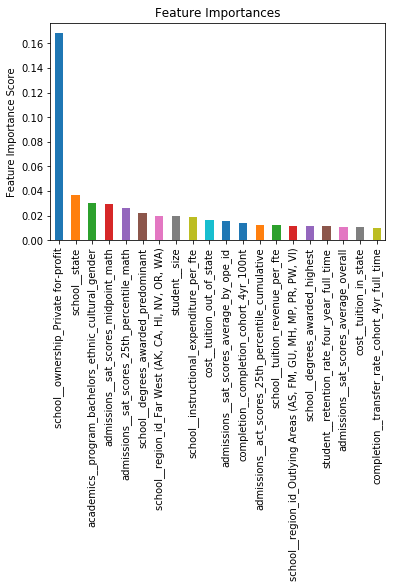

In [23]:
##### Train on the entire training dataset and make prediction for others #####
salary_clf = ExtraTreesRegressor(**salary_para)
modelfit(salary_clf, salary_train[predictor], salary_train.school__faculty_salary, performCV=False)

In [24]:
salary_pred = salary_clf.predict(salary_unknown.drop('school__faculty_salary', axis=1))

In [25]:
# Create pandas Series for concat with known salary
salary_pred = pd.Series(salary_pred, pred_rows, name='school__faculty_salary', copy=True)

In [26]:
# Concatenate with known salary
salary_all = pd.concat([salary_train.school__faculty_salary, salary_pred])

In [27]:
# Replace original salary
X_conc_EDA = X_conc_EDA.drop('school__faculty_salary', axis=1).join(salary_all)

In [28]:
##### Verify whether there is still 0 in salary (imputed in very begininng) #####
X_conc_EDA.school__faculty_salary.value_counts().head(5)

5217.000000    13
4312.557143    13
4078.308571    13
5332.798571    13
4049.747143    12
Name: school__faculty_salary, dtype: int64

In [29]:
##### Split out train and test set #####
X_train_EDA_itp = X_conc_EDA.iloc[:(-X_test.shape[0]), :].copy()
X_test_EDA_itp = X_conc_EDA.iloc[(-X_test.shape[0]):, :].copy()

### Store as csv to be easier access ###
X_train_EDA_itp.to_csv('X_train_post.csv')
X_test_EDA_itp.to_csv('X_test_post.csv')


Model Report
RMSE Score (Train): 5.321058
CV Score : Mean  5.942463 | Std  0.09237017 | Min  5.819221 | Max  6.045927


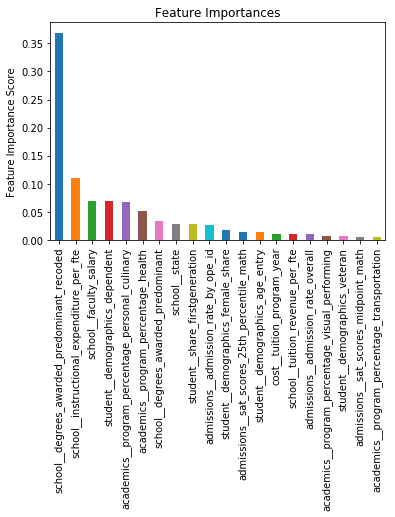

In [33]:
##### Benchmark Model again to verify improvement #####
modelfit(clf_benchmark, X_train_EDA_itp, y_train)

### Summary of Salary Interpolation

Compared to benchmark model, after interpolation with ExtraTreesRegressor, mean, std, min and max of CV score are all decreasing.

Therefore, accept this feature engineering.

**PS: benchmark model performance**

RMSE Score (Train): 5.331973

CV Score : Mean  6.049863 | Std  0.1349426 | Min  5.880425 | Max  6.272654

## Step 5: Interation of Single Model Selection

As stated above, tree based models will be considered here. Concretely, including:

- AdaBoostRegressor + DecisionTreeRegressor
- GradientBoostingRegressor
- RandomForestRegressor
- ExtraTreeRegressor
- XGBRegressor
- LGBMRegressor

In [34]:
##### Import processed data #####
X_train_post = pd.read_csv('X_train_post.csv')
X_test_post = pd.read_csv('X_test_post.csv')

In [35]:
##### Split out test set #####
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_post,
                                                          y_train,
                                                          test_size=0.15,
                                                          random_state=8828)

In [36]:
##### Quick and Dirty #####
model_sp = { 
    'ada':AdaBoostRegressor(DecisionTreeRegressor()),
    'gbr':GradientBoostingRegressor(),
    'rf':RandomForestRegressor(),
    'etr': ExtraTreesRegressor(),
    'xgb':XGBRegressor(),
    'lgbm':LGBMRegressor(),
}

param_sp = {
    'ada': {'random_state':[8828]},
    'gbr': {'random_state':[8828]},
    'rf': {'random_state':[8828]},
    'etr': {'random_state':[8828]},
    'xgb': {'random_state':[8828]},
    'lgbm': {'random_state':[8828]},
}

clf = EstimatorSelectionHelper(model_sp,param_sp)
clf.fit(X_train_f, y_train_f.squeeze(),
        n_iter=1, cv=5, n_jobs=-1, verbose=2,
        scoring='neg_mean_squared_error', refit=True,
        test_set=[X_val_f,y_val_f.squeeze()])

Running RandomizedSearchCV for ada.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Running RandomizedSearchCV for gbr.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


Running RandomizedSearchCV for rf.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


Running RandomizedSearchCV for etr.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Running RandomizedSearchCV for xgb.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


Running RandomizedSearchCV for lgbm.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


,test_set_score
etr,-14.443025
ada,-14.477538
lgbm,-18.042234
rf,-18.839006
gbr,-26.859359
xgb,-26.890467


In [37]:
clf.score_summary()

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,estimator,mean_test,mean_train,random_state,std_test,std_train
0,ada,-15.768,-0.0146945,8828,0.6237,0.000626343
3,etr,-15.8749,-3.18088e-07,8828,0.948474,4.75064e-07
5,lgbm,-17.7847,-9.09121,8828,0.714733,0.0987253
2,rf,-19.5666,-3.60983,8828,0.772685,0.163845
4,xgb,-26.2171,-22.112,8828,1.16625,0.276225
1,gbr,-26.2575,-21.7327,8828,0.995724,0.36733


In [ ]:
##### Define search space #####
### Using Scipy distribution for coarse step ###
# AdaBoostRegressor + DecisionTreeRegressor
adaDT_adapara = {'n_estimators':[200, 400, 600], 
                 'random_state':8828, 
                 'learning_rate':[0.1, 0.3, 1]}

adaDT_DTpara = {'max_depth':None, 
                'min_samples_split':[4, 6, 8], 
                'max_features':'auto'}

# GradientBoostingRegressor

gbr_para = {'n_estimators':[400, 600, 800], 
            'random_state':8828,
            'max_depth':[4, 6, 8],
            'max_features':['auto', 'sqrt'],
            'min_samples_split':None}

# RandomForestRegressor

rf_para = {'n_estimators':[400, 600, 800], 
            'random_state':8828,
            'max_depth':[4, 6, 8],
            'max_features':['auto', 'sqrt'],
            'min_samples_split':None}

# ExtraTreeRegressor

# XGBRegressor

# LGBMRegressor

## Step 6: Stacking Models